# _(Vreeswijk & Sompolinsky, 1996)_ E/I balanced network

## Overviews

Van Vreeswijk and Sompolinsky proposed E-I balanced network in 1996 to explain the temporally irregular spiking patterns. They suggested that the temporal variability may originated from the balance between excitatory and inhibitory inputs.

There are $N_E$ excitatory neurons and $N_I$ inbibitory neurons.

An important feature of the network is random and sparse connectivity. Connections between neurons $K$ meets $1 << K << N_E$. 

## Implementations

In [1]:
import brainpy as bp
import numpy as np

bp.backend.set('numba')

Dynamic of membrane potential is given as:

$$ \tau \frac {dV_i}{dt} = -(V_i - V_{rest}) + I_i^{ext} + I_i^{net} (t) $$

where $I_i^{net}(t)$ represents the synaptic current, which describes the sum of excitatory and inhibitory neurons.

$$ I_i^{net} (t) = J_E \sum_{j=1}^{pN_e} \sum_{t_j^\alpha < t} f(t-t_j^\alpha ) - J_I \sum_{j=1}^{pN_i} \sum_{t_j^\alpha < t} f(t-t_j^\alpha )$$

where 

$$ f(t) = \begin{cases} {\rm exp} (-\frac t {\tau_s} ), \quad t \geq 0 \\
0, \quad t < 0 \end{cases} $$

Parameters: $J_E = \frac 1 {\sqrt {pN_e}}, J_I = \frac 1 {\sqrt {pN_i}}$

We can see from the dynamic that network is based on leaky Integrate-and-Fire neurons, and we can just use `get_LIF` from `bpmodels.neurons` to get this model. 

In [2]:
tau = 10.
V_rest = -52.
V_reset = -60.
V_threshold = -50.
I = 3.

In [3]:

class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        self.V = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        super(LIF, self).__init__(size, **kwargs)

    @staticmethod
    @bp.odeint
    def int_f(V, t, Isyn):
        return (-V + V_rest + Isyn) / tau

    def update(self, _t):
        for i in range(self.num):
            V = self.int_f(self.V[i], _t, self.input[i])
            if V >= V_threshold:
                self.spike[i] = 1.
                V = V_reset
            else:
                self.spike[i] = 0.
            self.V[i] = V
            self.input[i] = I

The function of $I_i^{net}(t)$ is actually a synase with single exponential decay, we can also get it by using `get_exponential`.

In [4]:
tau_decay = 2.

In [5]:
class Syn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, g_max, delay=0., **kwargs):
        self.g_max = g_max

        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')

        self.s = bp.ops.zeros(post.num)
        self.g = self.register_constant_delay('g', post.num, delay_time=delay)

        super(Syn, self).__init__(pre, post, **kwargs)

    @staticmethod
    @bp.odeint
    def ints(s, t):
        return - s / tau_decay

    def update(self, _t):
        s = self.ints(self.s, _t)
        for pre_i, spike in enumerate(self.pre.spike):
            if spike:
                for post_i in self.pre2post[pre_i]:
                    s[post_i] += 1.
        self.s = s
        self.g.push(self.g_max * s)
        self.post.input += self.g.pull()

### Network

Let's create a neuron group with $N_E$ excitatory neurons and $N_I$ inbibitory neurons. We can appoint different synapse connection to the two kinds of neurons by using `group[:num_exc]` to get group slices. 

Use `conn=bp.connect.FixedProb(p)` to implement the random and sparse connections.

In [6]:
num_exc = 500
num_inh = 500
prob = 0.1

JE = 1 / np.sqrt(prob * num_exc)
JI = 1 / np.sqrt(prob * num_inh)

E_group = LIF(num_exc, monitors=['spike'])
E_group.V = np.random.random(num_exc) * (V_threshold - V_rest) + V_rest

I_group = LIF(num_inh, monitors=['spike'])
I_group.V = np.random.random(num_inh) * (V_threshold - V_rest) + V_rest

E2E = Syn(E_group, E_group, conn=bp.connect.FixedProb(prob=prob), g_max=JE)
E2I = Syn(E_group, I_group, conn=bp.connect.FixedProb(prob=prob), g_max=JE)
I2E = Syn(I_group, E_group, conn=bp.connect.FixedProb(prob=prob), g_max=-JI)
I2I = Syn(I_group, I_group, conn=bp.connect.FixedProb(prob=prob), g_max=-JI)

net = bp.Network(E_group, I_group, E2E, E2I, I2E, I2I)
net.run(duration=1000., report=True)

Compilation used 6.0234 s.
Start running ...
Run 10.0% used 0.055 s.
Run 20.0% used 0.104 s.
Run 30.0% used 0.151 s.
Run 40.0% used 0.210 s.
Run 50.0% used 0.262 s.
Run 60.0% used 0.309 s.
Run 70.0% used 0.355 s.
Run 80.0% used 0.403 s.
Run 90.0% used 0.451 s.
Run 100.0% used 0.498 s.
Simulation is done in 0.498 s.



### Visualization

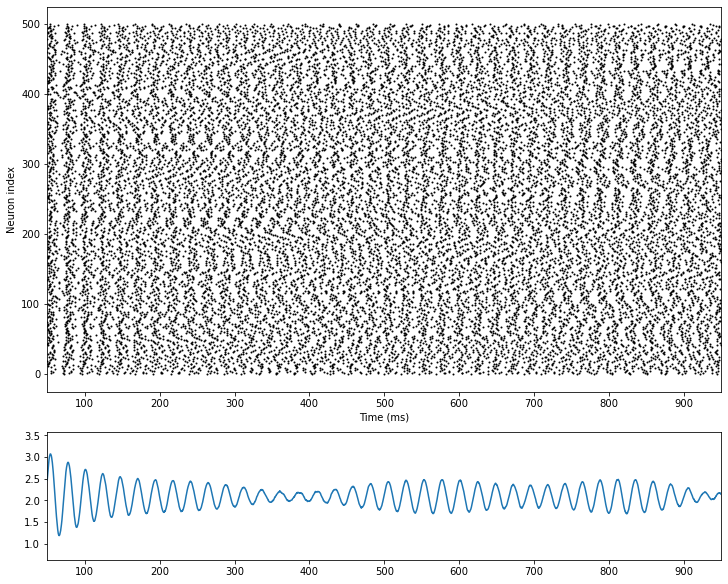

In [7]:
import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(4, 1, 2, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(net.ts, E_group.mon.spike, xlim=(50, 950))

fig.add_subplot(gs[3, 0])
rates = bp.measure.firing_rate(E_group.mon.spike, 5.)
plt.plot(net.ts, rates)
plt.xlim(50, 950)
plt.show()

## Reference

[1] Van Vreeswijk, Carl, and Haim Sompolinsky. "Chaos in neuronal networks with balanced excitatory and inhibitory activity." Science 274.5293 (1996): 1724-1726.